In [1]:
import numpy as np
import json
import pandas as pd
from utils import Timer
from joblib import Parallel, delayed
from traj2grid import Traj2Grid
import traj_dist.distance as tdist
from parameters import *
import numpy as np

timer = Timer()

#### 读取数据


In [2]:
file_path = "data/full/gps_20161101"
dict_path = "data/str_grid2idx_200_19227.json"
nrows = 1000000
vocab_size = 200


# read data
timer.tik("read data")
df = pd.DataFrame(pd.read_csv(file_path, header=None, nrows=nrows))
df.columns = ["name", "id", "time", "lon", "lat"]  # lon经度 lat纬度
timer.tok("read {}".format(file_path))


read data start
read data/full/gps_20161101 done, 0.732s after read data start


#### 去除超出范围的数据点


In [3]:
pad = 0.002


l = len(df)
df = df[(df["lon"] > 104.04214 + pad) & (df["lon"] < 104.12958 - pad)]
df = df[(df["lat"] > 30.65294 + pad) & (df["lat"] < 30.72775 - pad)]
print(f"剩{len(df)}/{l}个点，筛掉{round(100 - 100 * len(df) / l)}%")


剩948146/1000000个点，筛掉5%


#### GroupBy转换为1维点列

In [4]:
str_grid2idx = json.load(open(dict_path))
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
grid2idx = {eval(g): str_grid2idx[g] for g in list(str_grid2idx)}
t2g.set_vocab(grid2idx)
timer.tok(f"load dict{dict_path}")


def group_concat(group: pd.DataFrame):
    origin_traj = [((row["lon"]), row["lat"])
                   for index, row in group.iterrows()]
    traj_1d = t2g.convert1d(origin_traj)
    series = pd.Series({
        "origin_trajs": origin_traj,
        "trajs": traj_1d,
        "origin_len": len(origin_traj),
        "len": len(traj_1d),
        "max_lon": group["lon"].max(),
        "max_lat": group["lat"].max(),
        "min_lon": group["lon"].min(),
        "min_lat": group["lat"].min(),
    })
    return series


# group-apply
res = Parallel(n_jobs=44)(delayed(group_concat)(group)for name, group in df.groupby("id"))
df = pd.DataFrame(res)
timer.tok("group-apply")


load dictdata/str_grid2idx_200_19227.json done, 1.222s after read data start
group-apply done, 35.382s after read data start


##### 看看数据情况

count    5485.000000
mean       20.022789
std        25.441980
min         0.000000
25%         0.000000
50%         7.000000
75%        36.000000
max       145.000000
Name: len, dtype: float64

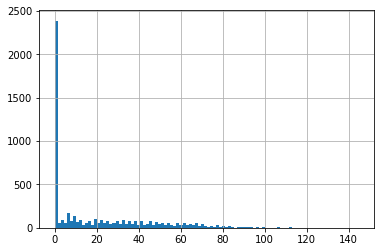

In [5]:
df['len'].hist(bins=100)
df['len'].describe()

#### 过滤过长过短轨迹

In [6]:
dff = df[(df["len"] > 10) & (df["len"] < 128)]
print(f"剩{len(dff)}/{len(df)}条轨迹，筛掉{round(100 - 100 * len(dff) / len(df))}%")


剩2510/5485条轨迹，筛掉54%


#### 生成pair-wise轨迹距离矩阵


In [22]:
# dff = dff.reset_index()
origin_trajs = dff["origin_trajs"].to_list()
arr = [np.array(origin_traj) for origin_traj in origin_trajs]
length = len(arr)
dis_lists = [[] for i in range(length)]
dis_func = getattr(tdist, "discret_frechet")


def cal_dis(i, j, x, y, n):
    dis = dis_func(x, y)
    if i == j + 1 :
        timer.tok(f'{i}-{round((i * i) / (n * n) * 100, 2)}%')
    return i, j, dis


def is_possible(i,j):
    x02 = dff['max_lon'][i]
    y02 = dff['max_lat'][i]
    x01 = dff['min_lon'][i]
    y01 = dff['min_lat'][i]
    x12 = dff['max_lon'][j]
    y12 = dff['max_lat'][j]
    x11 = dff['min_lon'][j]
    y11 = dff['min_lat'][j]
    zx = abs(x01 + x02 -x11 - x12)
    x = abs(x01 - x02) + abs(x11 - x12)
    zy = abs(y01 + y02 - y11 - y12)
    y = abs(y01 - y02) + abs(y11 - y12)
    if not (zx <= x and zy <= y):
        return False
    return True


res = Parallel(n_jobs=44)(
    delayed(cal_dis)(i, j, arr[i], arr[j], length - 1) for i in range(length) for j in range(i))
timer.tok("calculate distance")
for (i, j, dis) in res:
    dis_lists[i].append(j, dis)
    dis_lists[j].append(i, dis)


2-0.0% done, 914.342s after read data start
1-0.0% done, 914.355s after read data start
3-0.0% done, 914.371s after read data start
4-0.0% done, 914.396s after read data start
5-0.0% done, 914.399s after read data start
6-0.0% done, 914.408s after read data start
7-0.0% done, 914.422s after read data start
8-0.0% done, 914.431s after read data start
9-0.0% done, 914.44s after read data start
10-0.0% done, 914.448s after read data start
11-0.0% done, 914.454s after read data start
12-0.0% done, 914.467s after read data start
13-0.0% done, 914.492s after read data start
14-0.0% done, 914.498s after read data start
15-0.0% done, 914.519s after read data start
16-0.0% done, 914.535s after read data start
17-0.0% done, 914.546s after read data start
18-0.01% done, 914.56s after read data start
19-0.01% done, 914.576s after read data start
20-0.01% done, 914.585s after read data start
21-0.01% done, 914.599s after read data start
22-0.01% done, 914.611s after read data start
23-0.01% done, 9

KeyboardInterrupt: 

#### 生成 Train Dataset 第六步：保存

In [ ]:
full = False

dis_lists = [sorted(dis_list, lambda x:x[1]) for dis_list in dis_lists]
sorted_index = [[t[0]for t in dis_list]for dis_list in dis_lists]
dis_lists = [[t[1]for t in dis_list]for dis_list in dis_lists]
dict_save = {'trajs': df["trajs"].to_list(), "sorted_index": sorted_index, 'origin_trajs': origin_trajs}
if full:
    dict_save["dis_matrix"] = dis_lists.tolist()
    json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_{vocab_size}_dataset_full.json", "w"))
else:
    json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_{vocab_size}_dataset_small.json", "w"))
timer.tok("save")


save done, 323.708s after read data start
